In [15]:
%load_ext nb_black

import pickle
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from collections import defaultdict
from datetime import datetime
from pprint import pprint
from tqdm import tqdm
import os

from pprint import pprint


import torch
from torch.utils.data import DataLoader, Dataset

DATA = "/home/I6356345/project/data/created_data/triplets.tsv"
SEED = 566


def savefig_and_show(figname):
    plt.savefig(figname + ".png", format="png", dpi=600)
    plt.savefig(figname + ".pdf", format="pdf")
    plt.show()


IMG_DIR = "../../img"

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [9]:
# Fix random seeds for reproducibility
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

<IPython.core.display.Javascript object>

## Read and tokenize dataset


In [3]:
def tokenize_columns(df, columns):
    # Create an empty vocabulary
    vocab = {}
    token_counter = 1  # Start token IDs from 1 (you can reserve 0 for padding if needed)

    # Function to add unique column values to the vocab
    def add_to_vocab(value):
        nonlocal token_counter
        if value not in vocab:
            vocab[value] = token_counter
            token_counter += 1

    # Add all unique values from the specified columns to the vocabulary
    for column in columns:
        df[column].apply(add_to_vocab)

    # Function to tokenize a column value based on the vocab
    def tokenize(value):
        return [vocab[value]]  # Return token ID as a list to keep compatibility with batch processing

    # Tokenize the specified columns
    for column in columns:
        df[f'tokenized_{column.lower().replace(" ", "_")}'] = df[column].apply(tokenize)

    # Combine tokenized concept and property into a single input sequence
    df['input_sequence'] = df.apply(lambda row: row['tokenized_concept'] + row['tokenized_property'], axis=1)

    return df, vocab


class TripletDataset(Dataset):
    def __init__(self, df):
        self.inputs = df['input_sequence'].tolist()
        self.targets = df['tokenized_related_concept'].tolist()

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        input_sequence = torch.tensor(self.inputs[idx], dtype=torch.long)
        target_sequence = torch.tensor(self.targets[idx], dtype=torch.long)
        return input_sequence, target_sequence


<IPython.core.display.Javascript object>

In [4]:
# Load TSV data
data = pd.read_csv(DATA, sep="\t")
df = data.sample(n=100000, random_state=SEED)
# df = data[:100000]
df.head()

,Concept,Property,Related Concept
765212,Assessment using Griffith Mental Development S...,has_method,Evaluation - action
133111,Contact ulcer of vocal folds,has_associated_morphology,Ulcer
68501,Open tenotomy of extensor tendon of forearm,has_method,Division - action
656919,History of gastritis,has_associated_finding,Gastritis
189727,Disorder of catecholamine synthesis,mapped_to,Disorders of tyrosine metabolism


<IPython.core.display.Javascript object>

In [5]:
columns_to_tokenize = ["Concept", "Property", "Related Concept"]

df_tokenized, vocab = tokenize_columns(df, columns_to_tokenize)
display(df.head())
print("First 10 rows of Vocabulary:")
pprint(dict(list(vocab.items())[:10]))

,Concept,Property,Related Concept,tokenized_concept,tokenized_property,tokenized_related_concept,input_sequence
765212,Assessment using Griffith Mental Development S...,has_method,Evaluation - action,[1],[84235],[84450],"[1, 84235]"
133111,Contact ulcer of vocal folds,has_associated_morphology,Ulcer,[2],[84236],[211],"[2, 84236]"
68501,Open tenotomy of extensor tendon of forearm,has_method,Division - action,[3],[84235],[84451],"[3, 84235]"
656919,History of gastritis,has_associated_finding,Gastritis,[4],[84237],[10719],"[4, 84237]"
189727,Disorder of catecholamine synthesis,mapped_to,Disorders of tyrosine metabolism,[5],[84238],[84452],"[5, 84238]"


First 10 rows of Vocabulary:
{'Assessment using Griffith Mental Development Scale': 1,
 'Benign tumor of lateral nasal wall': 9,
 'Blood group antigen Tr^a^': 8,
 'Colostomy stenosis': 7,
 'Contact ulcer of vocal folds': 2,
 'Disorder of catecholamine synthesis': 5,
 'History of gastritis': 4,
 'Open tenotomy of extensor tendon of forearm': 3,
 'Specimen from lingula obtained by transbronchial biopsy': 10,
 'Specimen from peritoneum': 6}


<IPython.core.display.Javascript object>

## The Model

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim


class GPTLikeModel(nn.Module):
    def __init__(self, vocab_size, d_model, n_heads, num_layers, max_seq_len, seed=42):
        super(GPTLikeModel, self).__init__()
        # Fix random seed for reproducibility
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_len, d_model))

        self.transformer_layers = nn.ModuleList(
            [
                nn.TransformerDecoderLayer(d_model=d_model, nhead=n_heads)
                for _ in range(num_layers)
            ]
        )

        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, x):
        # Embedding and positional encoding
        seq_len = x.size(1)
        x = self.embedding(x) + self.positional_encoding[:, :seq_len, :]

        # Pass through each transformer decoder layer
        for layer in self.transformer_layers:
            x = layer(x, x)  # Decoder takes input twice in GPT-like models

        # Output layer
        logits = self.fc_out(x)
        return logits

<IPython.core.display.Javascript object>

## Train and save

In [7]:
# model hyperparameters
vocab_size = len(vocab) + 1  # Include 1 for padding (if needed)
d_model = 128  # Embedding size
n_heads = 4  # Number of attention heads
num_layers = 1  # Number of transformer layers
max_seq_len = 2  # Maximum sequence length (concept + property)
batch_size = 128
lr = 0.001
# data params
n_values = [50000, 60000, 70000, 80000, 90000, 100000]
# epochs
epochs = 500


results = defaultdict(list)
final_models = {}
# Set the number of iterations for each n value
num_iterations = 10

for n in n_values:
    # Repeat the training process for each n value num_iterations times
    for iteration in range(num_iterations):
        results_for_n = []  # Create a separate list for each n value
        print(f"Training with n={n}, iteration={iteration + 1}")
        # Set a different seed for each iteration to get different accuracies
        iteration_seed = SEED + iteration

        # PREPARE EVTH
        # Create dataset and data loader
        dataset = TripletDataset(df.sample(n=n, random_state=iteration_seed))
        train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        # Initialize the model
        model = GPTLikeModel(
            vocab_size, d_model, n_heads, num_layers, max_seq_len, seed=iteration_seed
        )

        # Move the model to GPU if available
        device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
        model = model.to(device)

        # Define the optimizer and loss function
        optimizer = optim.Adam(model.parameters(), lr=lr)
        criterion = nn.CrossEntropyLoss()

        # RUN LAUNCHING

        # Training and testing loop (memorization task)
        model.train()

        for epoch in range(epochs):
            total_loss = 0
            model.train()  # Set model to training mode

            # Training on the same data
            for batch in tqdm(train_loader):
                inputs, targets = batch
                inputs = inputs.to(device)
                targets = targets.to(device)

                # Forward pass
                optimizer.zero_grad()  # can be placed anywhere before loss.backward
                outputs = model(inputs)

                # We only care about the first token in the output sequence
                outputs = outputs[:, 0, :]  # Shape becomes: (batch_size, vocab_size)

                targets = targets.view(-1)  # Flatten the targets

                # Compute loss
                loss = criterion(outputs, targets)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            print(f"Epoch {epoch + 1}, Training Loss: {total_loss / len(train_loader)}")
            if epoch % 2 != 0:
                continue
            # Testing on the same data (memorization check)
            model.eval()  # Set model to evaluation mode
            correct = 0
            total = 0
            with torch.no_grad():
                for batch in tqdm(train_loader):  # Testing on the same dataset
                    inputs, targets = batch
                    inputs = inputs.to(device)
                    targets = targets.to(device)

                    outputs = model(inputs)
                    outputs = outputs[:, 0, :]  # Only take the first token prediction
                    predicted = torch.argmax(outputs, dim=1)

                    total += targets.size(0)
                    correct += (predicted == targets.view(-1)).sum().item()
            #             print(total, correct)

            accuracy = 100 * correct / total
            print(f"Epoch {epoch + 1}, Memorization Accuracy: {accuracy:.5f}%")
            results_for_n.append(accuracy)
        # Save the final model for this iteration
        final_models[(n, iteration)] = model

        # Save all accuracies for the current n value
        results[n].append(results_for_n)

    # Add timestamp to filename
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    # Pickle the results and final models dictionaries
    with open(
        f"../../../data/out_metrics/results_{timestamp}_50_100k_trans.pkl", "wb"
    ) as f:
        pickle.dump(results, f)
    with open(
        f"../../../data/out_models/models_{timestamp}_50_100k_trans.pkl", "wb"
    ) as f:
        pickle.dump(final_models, f)

Training with n=50000, iteration=1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 66.13it/s]


Epoch 1, Training Loss: 9.411625227964748


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 295.96it/s]


Epoch 1, Memorization Accuracy: 3.98800%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 73.58it/s]


Epoch 2, Training Loss: 8.363972474851877


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 71.03it/s]


Epoch 3, Training Loss: 7.821573420863627


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:01<00:00, 283.42it/s]


Epoch 3, Memorization Accuracy: 4.63600%


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:05<00:00, 75.16it/s]


Epoch 4, Training Loss: 6.4090372875828265


 71%|███████████████████████████████████████████████████████████████████████████████████████████                                     | 278/391 [00:03<00:01, 75.36it/s]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/I6356345/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3552, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_107622/3115943454.py", line 74, in <module>
    loss.backward()
  File "/home/I6356345/anaconda3/envs/py37/lib/python3.7/site-packages/torch/_tensor.py", line 489, in backward
    self, gradient, retain_graph, create_graph, inputs=inputs
  File "/home/I6356345/anaconda3/envs/py37/lib/python3.7/site-packages/torch/autograd/__init__.py", line 199, in backward
    allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/I6356345/anaconda3/envs/py37/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2098, in showtraceback
    stb = value._render_traceback_()
A

TypeError: object of type 'NoneType' has no len()

<IPython.core.display.Javascript object>

In [ ]:
# Add timestamp to filename
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
# Pickle the results and final models dictionaries
with open(
    f"../../../data/out_metrics/results_{timestamp}_50_100k_trans.pkl", "wb"
) as f:
    pickle.dump(results, f)
with open(f"../../../data/out_models/models_{timestamp}_50_100k_trans.pkl", "wb") as f:
    pickle.dump(final_models2, f)

## Draw

In [16]:
! ls ../../../data/out_metrics/results_*_50_100k_trans.pkl

../../../data/out_metrics/results_20241030_002102_50_100k_trans.pkl
../../../data/out_metrics/results_20241030_020035_50_100k_trans.pkl
../../../data/out_metrics/results_20241030_035655_50_100k_trans.pkl
../../../data/out_metrics/results_20241030_061020_50_100k_trans.pkl
../../../data/out_metrics/results_20241030_084050_50_100k_trans.pkl
../../../data/out_metrics/results_20241030_112648_50_100k_trans.pkl
../../../data/out_metrics/results_20241105_062400_50_100k_trans.pkl
../../../data/out_metrics/results_20241105_222648_50_100k_trans.pkl
../../../data/out_metrics/results_20241106_160815_50_100k_trans.pkl
../../../data/out_metrics/results_20241107_120404_50_100k_trans.pkl
../../../data/out_metrics/results_20241112_195523_50_100k_trans.pkl
../../../data/out_metrics/results_20241112_195754_50_100k_trans.pkl
../../../data/out_metrics/results_20241113_190311_50_100k_trans.pkl
../../../data/out_metrics/results_20241114_204601_50_100k_trans.pkl
../../../data/out_metrics/results_20241114_20460

<IPython.core.display.Javascript object>

In [17]:
with open(
    "../../../data/out_metrics/results_20241118_204546_50_100k_trans.pkl", "rb"
) as file:
    results = dict(pickle.load(file))
# pprint(results)

<IPython.core.display.Javascript object>

In [18]:
# Flatten the data while preserving iterations within each N_rows group
flattened_data = {
    "n_rows": [],
    "iteration": [],
    "epochs": [],
    "accuracy": [],
    "capacity": [],
}

# Iterate over each dataset size
for key, list_of_iterations in results.items():
    # For each iteration in the dataset size
    for i, iteration_list in enumerate(list_of_iterations):
        # Flatten the iteration list with epochs multiplied by 2 (0, 2, 4, ..., 18)
        for epoch, value in enumerate(iteration_list):
            flattened_data["n_rows"].append(key)
            flattened_data["iteration"].append(i)
            flattened_data["epochs"].append((epoch + 1) * 2)
            flattened_data["accuracy"].append(value)
            flattened_data["capacity"].append(int(value / 100 * key))

# Convert to DataFrame for plotting
results_melted = pd.DataFrame(flattened_data)
results_melted

,n_rows,iteration,epochs,accuracy,capacity
0,50000,0,2,7.998,3999
1,50000,0,4,10.142,5071
2,50000,0,6,10.138,5069
3,50000,0,8,10.420,5210
4,50000,0,10,39.228,19614
...,...,...,...,...,...
14995,100000,9,492,88.005,88005
14996,100000,9,494,87.999,87999
14997,100000,9,496,87.987,87987
14998,100000,9,498,88.033,88033


<IPython.core.display.Javascript object>

### Accuracy with epochs

In [19]:
def draw_acc_epochs(
    results_melted,
    cur_cutoff,
    layer_color_map,
    yticks=None,
    y_lines=None,  # Specific y level for horizontal line
    x="epochs",
    y="accuracy",
    xlabel="Epochs",
    ylabel="Accuracy, %",
    title="Mean accuracy with standard deviation per epoch of training\nfor different data sizes, activation functions, and layers amount",
):
    cur_results_melted = results_melted[results_melted.epochs <= cur_cutoff].rename(
        columns={
            "n_rows": "data size",
        }
    )

    # Plot with Seaborn
    sns.set_style(
        "white",
        rc={
            "xtick.bottom": True,
            "ytick.left": True,
        },
    )

    plt.figure(figsize=(5, 3))

    if y_lines is not None:
        for y_line in y_lines:
            plt.axhline(
                y=y_line,
                color="black",
                alpha=0.9,
                linestyle="--",
                linewidth=0.9,
            )
    sns.lineplot(
        data=cur_results_melted,
        x=x,
        y=y,
        hue="data size",  # Combined hue for Num_Layers and N_rows
        palette=layer_color_map,  # Ensure this supports the combined categories
        linewidth=1,
    )

    plt.xlim(0, cur_cutoff)

    # Add labels and legend
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(title="Configuration", bbox_to_anchor=(1.05, 1), loc="upper left")

    sns.despine(offset=2)
    # Optionally add yticks
    if yticks is not None:
        plt.yticks(yticks)  # Custom y-ticks

    # Show the plot
    plt.tight_layout()

<IPython.core.display.Javascript object>

30


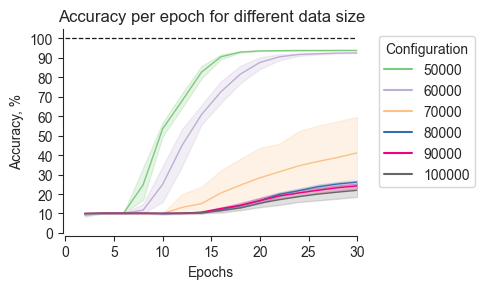

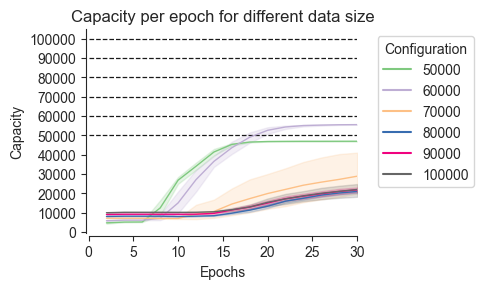

100


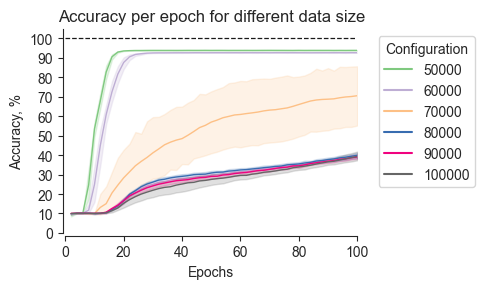

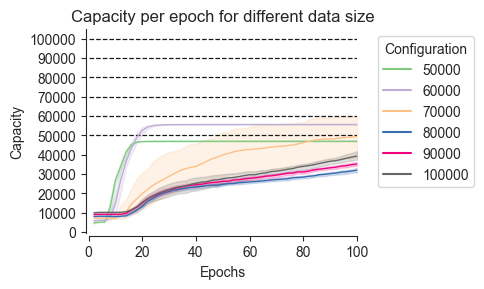

500


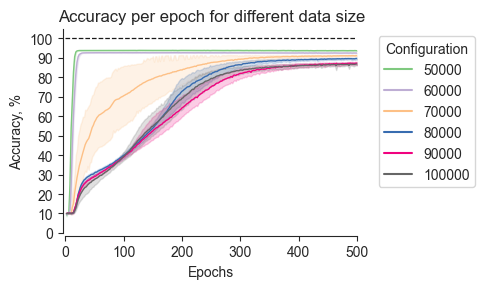

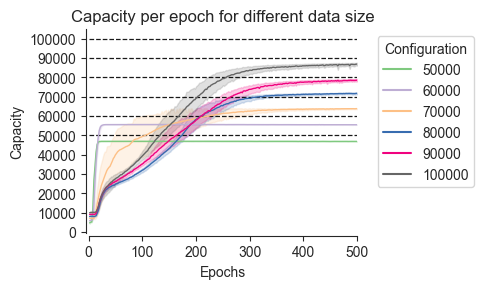

<IPython.core.display.Javascript object>

In [20]:
palette = sns.color_palette("Accent", n_colors=len(results) + 5)
new_palette = palette[:3] + palette[4:6] + palette[7:8]
for epochs in [30, 100, results_melted.epochs.max()]:
    print(epochs)
    draw_acc_epochs(
        results_melted,
        epochs,
        new_palette,
        yticks=np.arange(0, 101, 10),
        y_lines=[
            100,
        ],
        x="epochs",
        y="accuracy",
        xlabel="Epochs",
        ylabel="Accuracy, %",
        title="Accuracy per epoch for different data size",
    )
    savefig_and_show(os.path.join(IMG_DIR, f"1_datasize_acc_{epochs}"))
    draw_acc_epochs(
        results_melted,
        epochs,
        new_palette,
        yticks=np.arange(0, 100001, 10000),
        y_lines=np.arange(50000, 100001, 10000),
        x="epochs",
        y="capacity",
        xlabel="Epochs",
        ylabel="Capacity",
        title="Capacity per epoch for different data size",
    )
    savefig_and_show(os.path.join(IMG_DIR, f"1_datasize_cap_{epochs}"))

## Accuracy with rows

In [14]:
data_viol = results_melted[results_melted.epochs == max(results_melted.epochs)]
data_viol.head()

,n_rows,iteration,epochs,accuracy,capacity
249,50000,0,500,93.456,46728
499,50000,1,500,93.868,46934
749,50000,2,500,93.676,46838
999,50000,3,500,93.580,46790
1249,50000,4,500,93.744,46872


<IPython.core.display.Javascript object>

In [21]:
df = data_viol.set_index(["n_rows"])[["accuracy", "capacity"]]
grouped = df.groupby(["n_rows"]).agg(
    accuracy_mean=("accuracy", "mean"),
    accuracy_std=("accuracy", "std"),
    capacity_mean=("capacity", "mean"),
    capacity_std=("capacity", "std"),
)
grouped.round(2)

,accuracy_mean,accuracy_std,capacity_mean,capacity_std
n_rows,,,,
50000,93.62,0.15,46810.8,74.48
60000,92.42,0.10,55454.7,62.76
70000,91.10,0.54,63772.6,378.01
80000,89.63,0.83,71705.7,662.83
90000,87.24,1.21,78517.0,1086.31
100000,86.78,1.24,86775.5,1241.82


<IPython.core.display.Javascript object>

In [ ]:
def draw_violins(
    data_viol,
    x,
    y,
    xlabel,
    ylabel,
    title,
    yticks=None,
    hue=None,
    return_ax=False,
    ax=None,
):
    PALETTE_PARAMS = "Accent"
    PALETTE = "Set2"
    data_dict = {
        "x": x,
        "y": y,
        "palette": new_palette,
        "linewidth": 0.5,
    }
    if hue:
        data_dict["hue"] = hue
        data_dict["dodge"] = True
    if ax:
        data_dict["ax"] = axs[col]

    sns.set_style(
        "white",
        rc={
            "xtick.bottom": True,
            "ytick.left": True,
        },
    )
    ax = sns.violinplot(
        data_viol, **data_dict, cut=0, legend=False, scale="count", alpha=0.3
    )
    plt.setp(ax.collections, alpha=0.6)
    ax = sns.stripplot(data_viol, **data_dict, legend=True, alpha=0.9)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    sns.despine(offset=2)
    # Optionally add yticks
    if yticks is not None:
        ax.set_yticks(yticks)  # Custom y-ticks
    if return_ax:
        return ax

In [ ]:
int(data_viol.accuracy.min())

In [ ]:
draw_violins(
    data_viol,
    x="n_rows",
    y="accuracy",
    xlabel="Data size",
    ylabel="Accuracy, %",
    title="Accuracy by rows to memorize",
    yticks=np.arange(84, 101, 2),
)
plt.show()
draw_violins(
    data_viol,
    x="n_rows",
    y="capacity",
    xlabel="Data size",
    ylabel="Capacity",
    title="Capacity by rows to memorize",
    yticks=np.arange(0, 100001, 10000),
)
plt.show()